# 1 K-means Clustering

Run k-means on MNIST with k = 5, 10, 20 cluster centers and visualize the centers. You must implement the k-means algorithm yourself.

### 1.1. Use the image data at `mnist_data=images.mat`. There 60,000 unlabeled images. Each image contains 28 x 28 pixels.

In [1]:
import os
import numpy as np
from scipy.io import loadmat
from KMeans import KMeans
from KNN import KNN
from ALSLatentFactorModel import ALSLatentFactorModel
from utils import plot_kmeans, kmeans_cost, validation_accuracy_and_MSE, \
    reshape_array, reshape_long_to_wide, wide_to_long
from eigenface_utils import *
import matplotlib.pylab as plt

%matplotlib inline

np.random.seed(289)

images = loadmat('./mnist_data/images.mat')['images'].T.reshape(60000, 784)

In [2]:
k5 = KMeans(k=5, iterations=50)
k5.fit(images)

In [3]:
k10 = KMeans(k=10, iterations=50)
k10.fit(images)

In [4]:
k15 = KMeans(k=15, iterations=50)
k15.fit(images)

In [11]:
k20 = KMeans(k=20, iterations=50)
k20.fit(images)

### 1.2 Visualize the cluster centers, viewing each coordinate as a pixel.

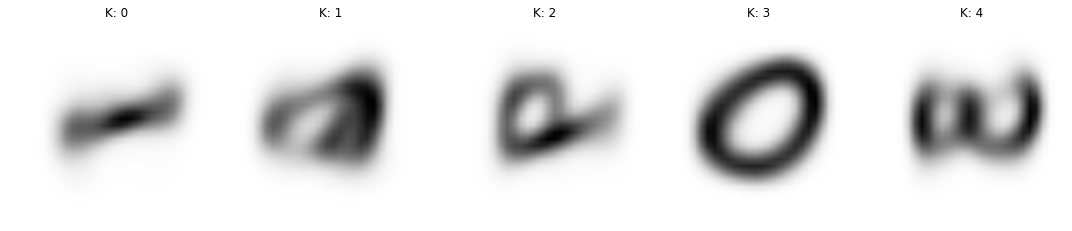

In [6]:
plot_kmeans(k5.kmeans, ncols=5, nrows=1, figsize=(15,5))

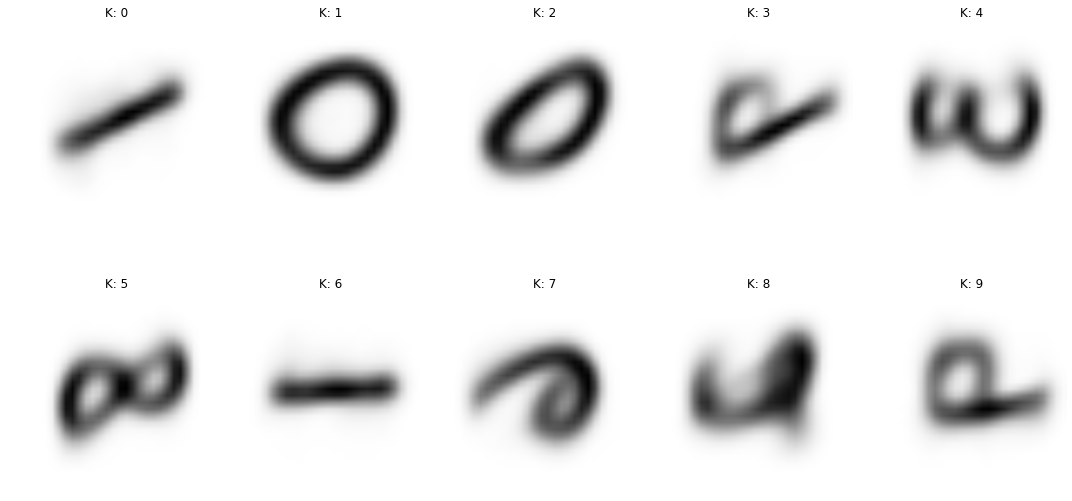

In [7]:
plot_kmeans(k10.kmeans, ncols=5, nrows=2, figsize=(15,10))

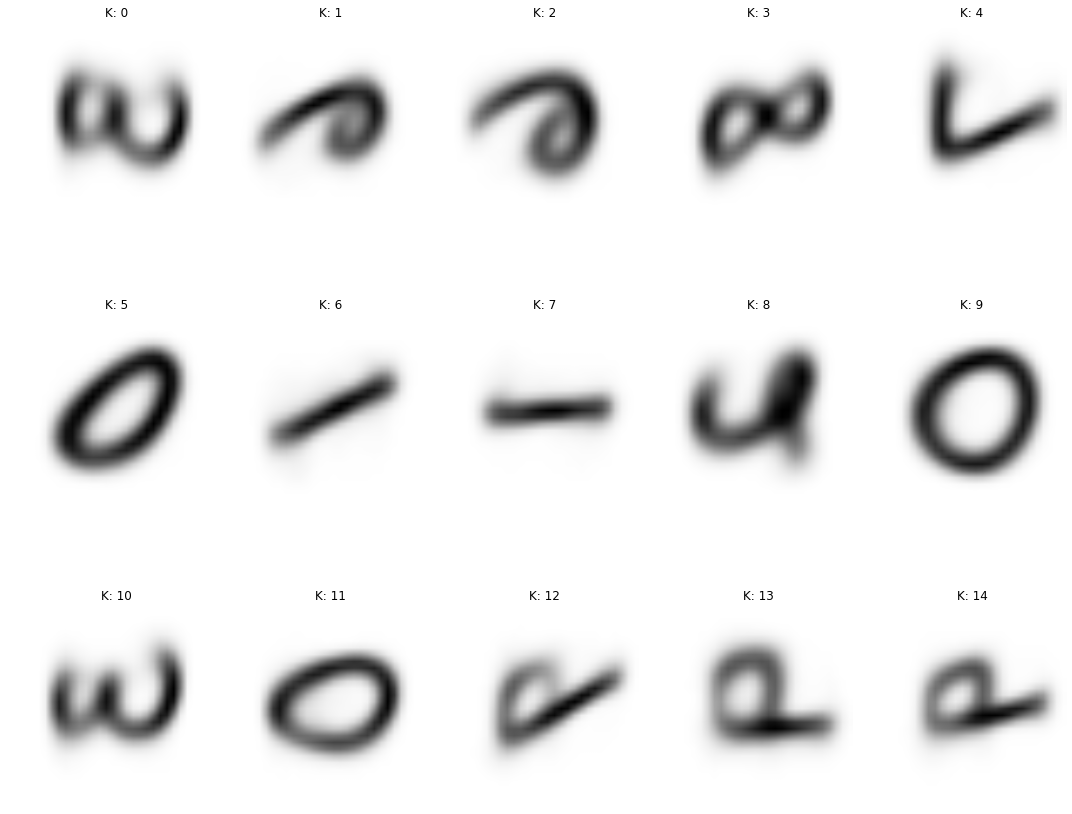

In [8]:
plot_kmeans(k15.kmeans, ncols=5, nrows=3, figsize=(15,15))

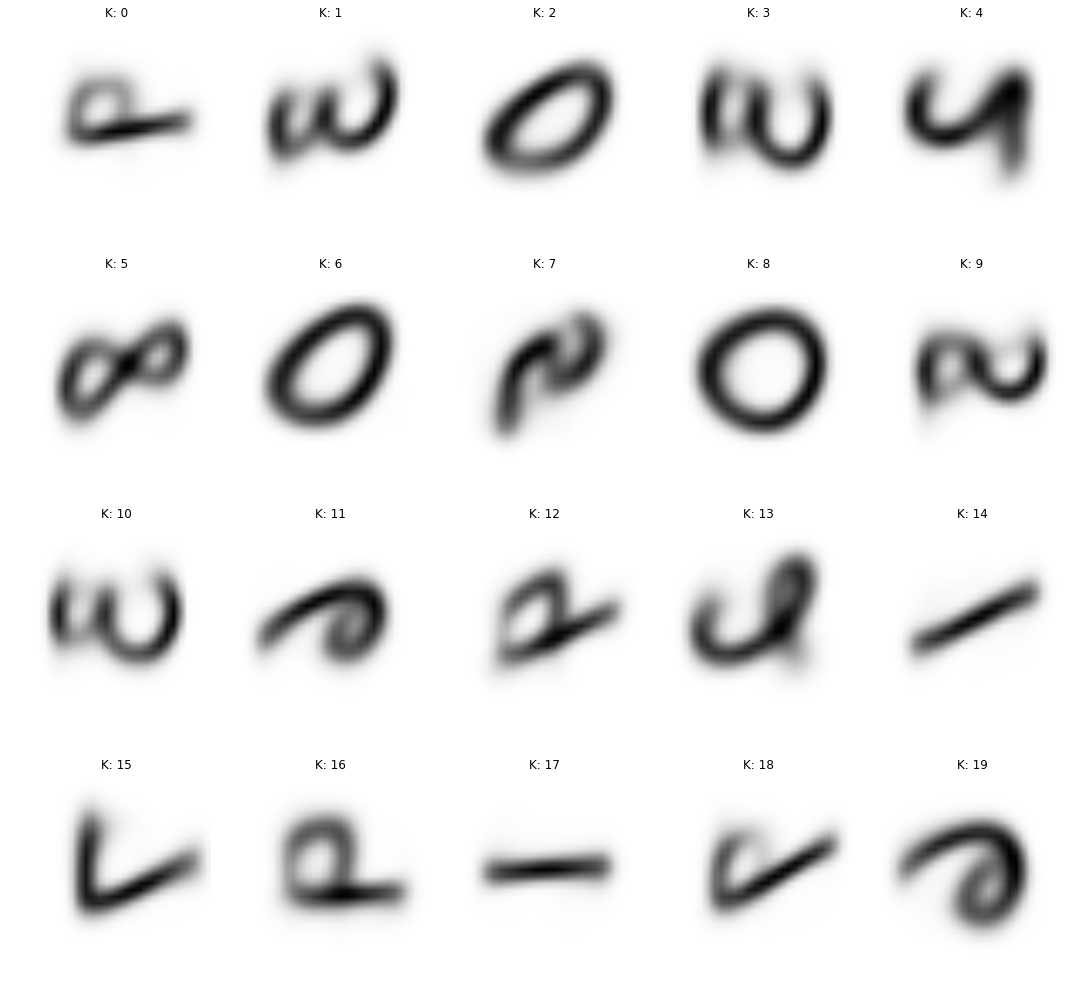

In [12]:
plot_kmeans(k20.kmeans, ncols=5, nrows=4, figsize=(15,15))

### 1.3 Repeat the algorithm for multiple times with random initialization. Does the k-mean loss vary in different runs?

**Answer:**

Yes, k-means loss does vary over repeated runs.

In [14]:
kmeans5_1 = KMeans(k=5, iterations=50)
kmeans5_1.fit(images)

In [15]:
kmeans5_2 = KMeans(k=5, iterations=50)
kmeans5_2.fit(images)

In [16]:
kmeans5_3 = KMeans(k=5, iterations=50)
kmeans5_3.fit(images)

In [18]:
[kmeans_cost(x) for x in [k5, kmeans5_1, kmeans5_2, kmeans5_3]]

[186266.03242319796,
 186741.78820123739,
 186257.42016646301,
 186255.62269084412]

# 2 Joke Recommender System

You will build a personalized joke recommender system. There are $m = 100$ jokes and $n = 24,983$ users. As historical data, every user read a subset of jokes and rated them. The goal is to recommend more jokes, such that the recommended jokes match the individual user's sense of humour.

### 2.1 Data Format
The historical rating is represented by a matrix $R \in R^{n \times m}$. The entry $R_{ij}$ represents the user $i$'s rating on joke $j$. The rating is a real number in [-10, 10]: a higher value represents that the user is more satisfied with the joke. If the joke is not rated, then the corresponding entry value is `NaN`.

The directory `joke_data/jokes/` contains the text of all 100 jokes. Read them before you start! In addition, you are provided with three files at `joke data/`:

* `joketrain.mat` is given as the training data. It contains the matrix R specified above.
* `validation.txt` contains user-joke pairs that doesn't appear in the training set. Each line takes the form `"i,j,s"`, where `i` is the user index, `j` is the joke index, `s` indicates whether the user likes the joke. More specifucally, `s = 1` if and only if the user gives a positive rating to the joke.
* `query.txt` contains user-joke pairs that are neither in the training set nor in the validation set. Each line takes the form `"id,i,j"`. You are asked to predict if user `i` likes joke `j`. The integer id is a unique id for the user-joke pair. Use it to submit the prediction to Kaggle (see Section 2.4).

### 2.2 Warm-up
Let's start with the simplest recommender system: recommend the joke by its average rating in the training set. In particular, assert that any user will like the joke if its average rating is positive. Report your prediction accuracy on the validation set.

In [19]:
jokes_nan = loadmat('./joke_data/joke_train.mat')['train']
validation = np.loadtxt('./joke_data/validation.txt', delimiter=',')
query = np.loadtxt('./joke_data/query.txt', delimiter=',', dtype=np.int)

joke_avg_score_array = np.where(np.nanmean(jokes_nan, axis=0) > 0, 1., 0.)
joke_avg_scores = np.array([joke_avg_score_array,]*100)
avg_acc, _ = validation_accuracy_and_MSE(validation, joke_avg_scores)
print(avg_acc)

0.620325203252


Next, we turn to a more advanced system where personal preferences are taken into account. Replace all missing values of $R$ by zero, then measure the distance of any two users by the Euclidean distance between their rating vectors. For each user, find the k nearest neighbors of him/her, then make the prediction by averaging the ratings of these neighbors. Report your prediction accuracy on the validation set with $k = 10, k = 100$ and $k = 1,000$. How are the accuracies compare to the simple system?

**Answer:**

KNN with k = 100 and 1000 did better than simply using the average for all ratings.

In [20]:
jokes_0 = jokes_nan.copy()
jokes_0[np.isnan(jokes_0)] = 0

user_ids = np.unique(validation[:,0])
jokes_test = reshape_long_to_wide(validation, user_ids)

In [21]:
knn_10 = KNN(k=10)
knn_10.fit(jokes_0)
jokes_knn10_scores = knn_10.predict(jokes_test)
knn_10_acc, _ = validation_accuracy_and_MSE(validation, jokes_knn10_scores)
print('KNN=10 Accuracy: {}'.format(knn_10_acc))

KNN=10 Accuracy: 0.5964769647696477


In [22]:
knn_100 = KNN(k=100)
knn_100.fit(jokes_0)
jokes_knn100_scores = knn_100.predict(jokes_test)
knn_100_acc, _ = validation_accuracy_and_MSE(validation, jokes_knn100_scores)
print('KNN=100 Accuracy: {}'.format(knn_100_acc))

KNN=100 Accuracy: 0.6802168021680217


In [23]:
knn_1000 = KNN(k=1000)
knn_1000.fit(jokes_0)
jokes_knn1000_scores = knn_1000.predict(jokes_test)
knn_1000_acc, _ = validation_accuracy_and_MSE(validation, jokes_knn1000_scores)
print('KNN=1000 Accuracy: {}'.format(knn_1000_acc))

KNN=1000 Accuracy: 0.6677506775067751


### 2.3 Latent Factor Model

Latent factor model is the state-of-the-art method for personalized recommendation. It learns a vector representation $u_i \in \mathbb{R}^d$ for each user and a vector representation $v_j \in \mathbb{R}^d$ for each joke, such that the inner product $\langle u_i, v_j \rangle$ approximates the rating $R_{ij}$ . You will build a simple latent factor model.

#### 2.3.1 Replace all missing values by zero. Then use principle component analysis (PCA) to learn vector representation for users and jokes. Note that you are NOT allowed to use any inbuilt functions for PCA in MATLAB.

In [24]:
U, s, Vt = np.linalg.svd(jokes_0, full_matrices=False)
V = Vt.T

# sort principal components by size of singular values
ind = np.argsort(s)[::-1]
U = U[:, ind]
s = s[ind]
V = V[:, ind]
S = np.diag(s)

#### 2.3.2 Evaluate the learnt vector representations by mean squared error:

$$\textrm{MSE} = \sum_{(i,j) \in S} (\langle u_i, v_j \rangle - R_{ij})^2, \textrm{where} \; S := \{(i,j) : R_{ij} \neq NaN\}$$

#### Try $d = 2, 5, 10, 20$. How does the MSE vary as a function of $d$? Use the inner product $\langle u_i, v_i\rangle$ to predict if user $i$ likes joke $j$. Report prediction accuracies on the validation set.

In [25]:
for d in [2, 5, 10, 20]:
    SVt  = S[:d,:d].dot(V[:,:d].T)
    USVt = U[:,:d].dot(SVt)
    prediction = np.where(USVt > 0, 1., 0.)
    acc, mse = validation_accuracy_and_MSE(validation, prediction)
    print("D = {}".format(d))
    print("  MSE = {:.3f}".format(mse))
    print("  Accuracy = {:.3f}".format(acc))

D = 2
  MSE = 0.295
  Accuracy = 0.705
D = 5
  MSE = 0.285
  Accuracy = 0.715
D = 10
  MSE = 0.283
  Accuracy = 0.717
D = 20
  MSE = 0.314
  Accuracy = 0.686


#### 2.3.3  For sparse data, replacing all missing values by zero is not a completely satisfying solution. A missing value means that the user has not read the joke, but doesn't mean that the rating should be zero. A more reasonable choice is to minimize the MSE only on rated joke. Let's define a loss function:

$$L \Big(  \{ u_i \}, \{ v_i \} \Big) := \sum_{(i,j) \in S} (\langle u_i, v_j \rangle - R_{ij})^2 + \lambda \sum^n_{i=1} \| u_i \|^2_2 + \lambda \sum_{j=1}^m \| v_j \|^2_2$$

#### where set S has the same definition as in equation (1) and $\lambda > 0$ is the regularization coefficient. Implement an algorithm to learn vector representations by minimizing the loss function $L(\{u_i\},\{v_j\})$.

**Hint:** you may want to employ an alternating minimization scheme. First, randomly initialize $\{u_i\}$ and $\{v_j\}$. Then minimize the loss function with respective to $\{u_i\}$ by treating $\{v_j\}$ as constant vectors, and minimize the loss function with respect to $\{v_j\}$ by treating $\{u_i\}$ as constant vectors. Iterate these two steps until both $\{u_i\}$ and $\{v_j\}$ converge. Note that when one of $\{u_i\}$ or $\{v_j\}$ is given, minimizing the loss function with respect to the other part has closed-form solutions.

#### 2.3.4 Compare the resulting MSE and the prediction error with Step 2. Note that you need to tune the hyper-parameter $\lambda$ to optimize the performance.

In [26]:
for d in [2, 5, 10, 20]:
    als = ALSLatentFactorModel(d=d, λ=.001, num_iters=10)
    als.fit(jokes_nan)
    als_predictions = als.predict()
    acc, mse = validation_accuracy_and_MSE(validation, als_predictions)
    print("D = {}".format(d))
    print("  MSE = {:.3f}".format(mse))
    print("  Accuracy = {:.3f}".format(acc))

D = 2
  MSE = 0.295
  Accuracy = 0.705
D = 5
  MSE = 0.284
  Accuracy = 0.716
D = 10
  MSE = 0.288
  Accuracy = 0.712
D = 20
  MSE = 0.305
  Accuracy = 0.695


### 2.4 Recommending Jokes

#### 2.4.1 Using the methods you have implemented to predict the users' preference on unread jokes. For each line `"id,i,j"` in the query file, output a line `"id,s"` to a file named kaggle_submission.txt. Here, `s = 1` means that user `i` will give a positive rating to joke `j`, while `s = 0` means that the user will give a non-positive rating. The first line of `kaggle_submission.txt` should be the field titles: `"Id,Category"` . Submit `kaggle_submission.txt` to Kaggle.

**Answer:**

My username on Kaggle is **jsemer**. I used an ensemble of KNN (k=100), ALS, and SVD for my prediction. My score on the public leaderboard was 72.3%.

In [27]:
# knn_100 = KNN(k=100)
# knn_100.fit(jokes_0)
# KNN_prediction = knn_100.predict(jokes_0)

# als = ALSLatentFactorModel(d=10, λ=.001, num_iters=10)
# als.fit(jokes_nan)
# ALS_prediction = als.predict()

# SVt  = S[:10,:10].dot(V[:,:10].T)
# USVt = U[:,:10].dot(SVt)
# SVD_prediction = np.where(USVt > 0, 1., 0.)

# kaggle_array = wide_to_long(ALS_prediction, query)
# kaggle_submission = np.vstack((query[:,0], kaggle_array)).T
# np.savetxt("./als_d10_kaggle.csv", kaggle_submission, fmt="%i", delimiter=",", header="Id,Category", comments="")

# 3. Eigenfaces

#### You need to do the following steps to nd eigenfaces and the best matches.

#### 3.1. Compute eigenfaces from the celebrity faces (after applying the binary mask). Visualize the top 10 eigenfaces. What kind of variations do the top eigenfaces seem to correspond to?

**Answer:**

Some of variations correspond to shawdows from the left side, shows from the top (blueish ones?), light coming from the bottom, dark eyes, makeup, and facial hair.

In [28]:
mask = loadmat("eigenfaces_data/mask.mat")['mask']
unmasked_pixels = np.where(mask)

celeb_dir = os.path.join('eigenfaces_data', 'CelebrityDatabase')
celeb_files = os.listdir(celeb_dir)
student_dir = os.path.join('eigenfaces_data', 'StudentDatabase')
student_files = os.listdir(student_dir)

celebs = read_images(celeb_files, celeb_dir, unmasked_pixels)
students = read_images(student_files, student_dir, unmasked_pixels)

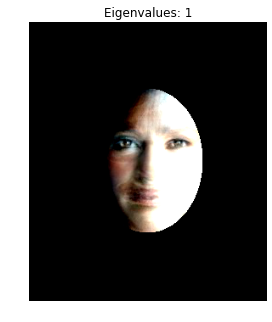

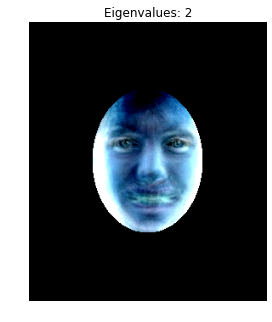

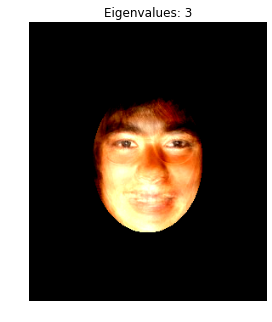

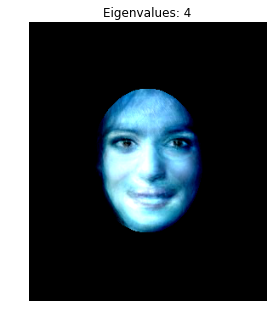

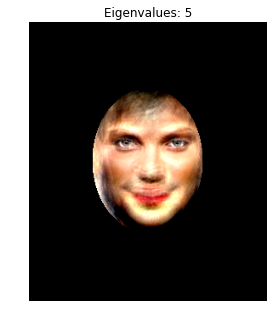

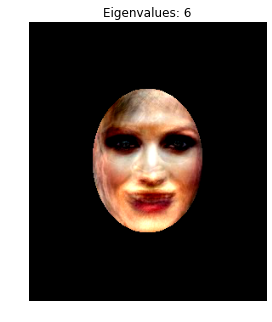

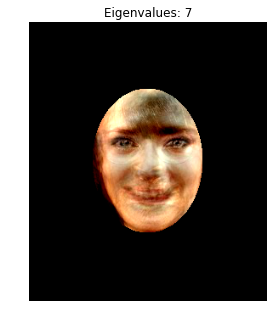

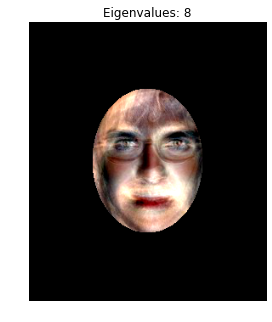

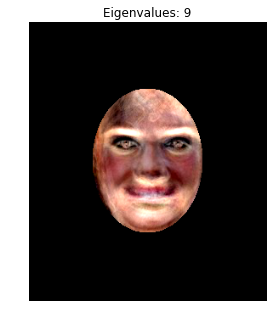

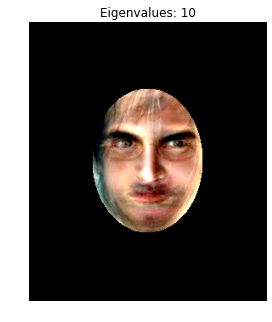

In [29]:
plot_eigenfeatures(celebs, 10, mask, unmasked_pixels)

#### 3.2. Reconstruct 5 celebrity faces from only the top 10 eigenfaces and visualize some of them with the original image and the reconstructed image side-by-side. Plot the average $l 2$-error as a function of the number of eigenfaces used to reconstruct the original image.

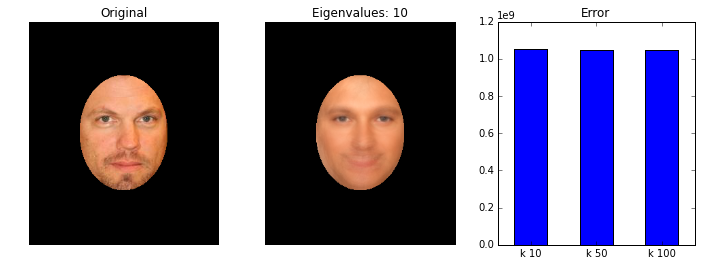

In [30]:
plot_eigenfaces(celebs, 0, mask, unmasked_pixels)

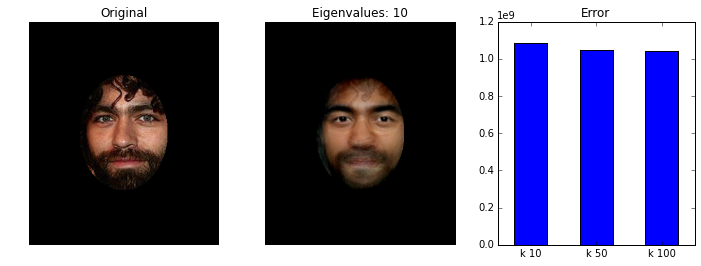

In [31]:
plot_eigenfaces(celebs, 1, mask, unmasked_pixels)

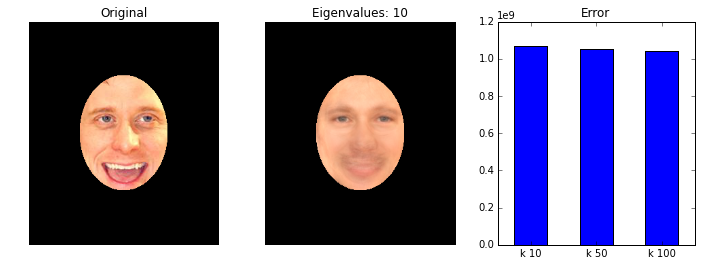

In [32]:
plot_eigenfaces(celebs, 2, mask, unmasked_pixels)

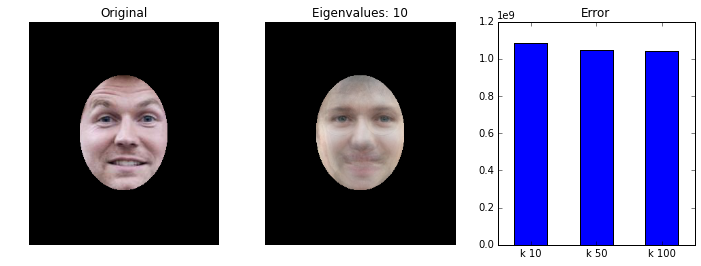

In [33]:
plot_eigenfaces(celebs, 3, mask, unmasked_pixels)

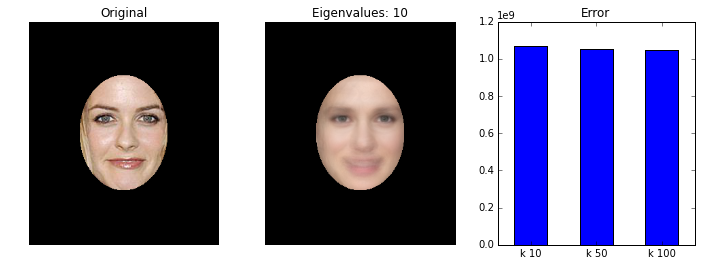

In [34]:
plot_eigenfaces(celebs, 4, mask, unmasked_pixels)

#### 3.3. Pick 5 student faces and reconstruct them with top 20 eigenfaces. Visualize these reconstructions as you did above in your write up. Plot the average $l 2$-error as a function of the number of eigenfaces to reconstruct the original image.

#### Include all the figures, numbers and answers to the questions in your report.